In [3]:
%run 'Flow-functions.ipynb'
%run 'Theano-functions.ipynb'

Overwriting /cluster/thashim/.theanorc
[GpuElemwise{exp,no_inplace}(<CudaNdarrayType(float32, vector)>), HostFromGpu(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.268345 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


# Preprocessing steps..
## Load single cell rnaseq- data
Data from (http://www.cell.com/cell/abstract/S0092-8674(15)00500-0), (http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE65525)

In [4]:
%%script /bin/bash
ls -ltr ../rnaseq

total 517960
-rw-r--r-- 1 thashim thashim 121832698 Jan 28  2015 GSM1599495_ES_d0_biorep_techrep1.csv
-rw-r--r-- 1 thashim thashim 167217403 Jan 28  2015 GSM1599496_ES_d0_biorep_techrep2.csv
-rw-r--r-- 1 thashim thashim  45535313 Jan 28  2015 GSM1599494_ES_d0_main.csv
-rw-r--r-- 1 thashim thashim  14867854 Jan 28  2015 GSM1599497_ES_d2_LIFminus.csv
-rw-r--r-- 1 thashim thashim  33248839 Jan 28  2015 GSM1599498_ES_d4_LIFminus.csv
-rw-r--r-- 1 thashim thashim  38954057 Jan 28  2015 GSM1599499_ES_d7_LIFminus.csv
-rw-r--r-- 1 thashim thashim  12444135 Jan 28  2015 GSM1599500_K562_cells.csv
-rw-r--r-- 1 thashim thashim  49126465 Jan 28  2015 GSM1599501_K562_pure_RNA.csv
-rw-r----- 1 thashim thashim  47144960 Dec 24 19:44 GSE65525_RAW.tar


In [5]:
file_list = ['GSM1599494_ES_d0_main.csv', 'GSM1599497_ES_d2_LIFminus.csv', 'GSM1599498_ES_d4_LIFminus.csv', 'GSM1599499_ES_d7_LIFminus.csv']
expt_names = ['d0','d2','d4','d7']
times = [0.0,2.0,4.0,7.0]

In [6]:
import pandas as pd
import numpy as np

In [7]:
table_list = []
for filein in file_list:
    table_list.append(pd.read_csv('../rnaseq/'+filein, header=None))

In [8]:
matrix_list = []
gene_names = table_list[0].values[:,0]
for table in table_list:
    matrix_list.append(table.values[:,1:].astype('float32'))

## Filter for genes

We want to remove all genes that are already stationary and model those separately. To do this, take the wasserstein distance for each gene between D0 and D7, and threshold on that.

For normalization use (http://www.biorxiv.org/content/early/2015/12/27/025528)

In [9]:
matrix_list[0].shape

(24175, 933)

In [10]:
cell_counts = [matrix.shape[1] for matrix in matrix_list]
print cell_counts

[933, 303, 683, 798]


In [11]:
def normalize_run(mat):
    rpm = np.sum(mat,0)/1e6
    detect_pr = np.sum(mat==0,0)/float(mat.shape[0])
    return np.log(mat*(np.median(detect_pr)/detect_pr)*1.0/rpm + 1.0)

In [12]:
norm_mat = [normalize_run(matrix) for matrix in matrix_list]
qt_mat = [np.percentile(norm_in,q=np.linspace(0,100,50),axis=1) for norm_in in norm_mat]

In [13]:
wdiv=np.sum((qt_mat[0]-qt_mat[3])**2,0)
w_order = np.argsort(-wdiv)

In [14]:
gene_names[w_order[0:100]]

array(['Krt8', 'Krt18', 'Tdh', 'Tagln', 'Mt1', 'Dppa5a', 'Mt2', 'Gsn',
       'Lgals1', 'Pou5f1', 'Krt19', 'Gm6083', 'Zfp42', 'Chchd10', 'Anxa2',
       'Fam25c', 'Mir690', 'Mylpf', 'Fxyd6', 'Sox2', 'Slc29a1', 'Rn4.5s',
       'Tdgf1', 'Cald1', 'Mkrn1', 'Pigp', 'Anxa3', 'Cnn2', 'Tpm1',
       '1700026D08Rik', 'S100a11', 'Cryab', 'L1td1', 'Tubb6', 'Krt7',
       'Mybl2', 'Tex19.1', 'Rhoc', 'Esrrb', 'Nanog', 'Ddx43', 'Cldn6',
       '1110036E04Rik', 'Hmces', 'Tcf15', 'Hist1h2ap', 'Pla2g10os', 'Etv4',
       'Eif4e3', 'BC018473', 'Actg2', 'Tagln2', 'Tnfrsf12a', 'Itpk1',
       'Ung', 'Tpm4', 'Utf1', 'Ccnd3', 'Csrp2', 'Pts', 'Gcsam', 'Cyr61',
       'Etv5', 'Csrp1', 'Mir8095', 'Tcea3', 'Rab33b', 'Klf2', 'Capn2',
       '1700010I14Rik', 'Api5', 'Mgl2', 'Mir6240', 'Anxa5', 'H2-T23',
       'Glipr2', 'Socs3', 'Vsig10l', 'Fbxo2', 'Jarid2', 'Acot5', 'Bard1',
       'Trap1a', 'Olfr1385', 'Plin2', 'Sept1', 'Gm5712', 'B230208H11Rik',
       'Pcbp4', 'Rab27a', 'Tacstd2', 'Cenpv', 'Zfp553', 'Aes', '

In [15]:
wid = w_order[9]

In [16]:
yin=[norm_in[wid,:].tolist() for norm_in in norm_mat]
xin=[[expt_names[i]]*len(yin[i]) for i in xrange(len(yin))]

In [17]:
def flatten(l):
    return np.array([item for sublist in l for item in sublist])

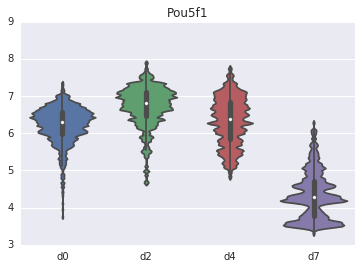

In [18]:
nzi = np.array(flatten(yin))>0
sns.violinplot(x=flatten(xin)[nzi],y=flatten(yin)[nzi],bw=0.05)
plt.title(gene_names[wid])

In [19]:
wsub = w_order[0:100]

## Impute zeroes

In [20]:
import numpy as np
from scipy import linalg
from numpy import dot

def nmf(X, latent_features, max_iter=100, error_limit=1e-6, fit_error_limit=1e-6, print_iter=200):
    """
    Decompose X to A*Y
    """
    eps = 1e-5
    print 'Starting NMF decomposition with {} latent features and {} iterations.'.format(latent_features, max_iter)
    #X = X.toarray()   I am passing in a scipy sparse matrix

    # mask
    mask = np.sign(X)

    # initial matrices. A is random [0,1] and Y is A\X.
    rows, columns = X.shape
    A = np.random.rand(rows, latent_features)
    A = np.maximum(A, eps)

    Y = linalg.lstsq(A, X)[0]
    Y = np.maximum(Y, eps)

    masked_X = mask * X
    X_est_prev = dot(A, Y)
    for i in range(1, max_iter + 1):
        # ===== updates =====
        # Matlab: A=A.*(((W.*X)*Y')./((W.*(A*Y))*Y'));
        top = dot(masked_X, Y.T)
        bottom = (dot((mask * dot(A, Y)), Y.T)) + eps
        A *= top / bottom

        A = np.maximum(A, eps)
        # print 'A',  np.round(A, 2)

        # Matlab: Y=Y.*((A'*(W.*X))./(A'*(W.*(A*Y))));
        top = dot(A.T, masked_X)
        bottom = dot(A.T, mask * dot(A, Y)) + eps
        Y *= top / bottom
        Y = np.maximum(Y, eps)
        # print 'Y', np.round(Y, 2)


        # ==== evaluation ====
        if i % print_iter == 0 or i == 1 or i == max_iter:
            print 'Iteration {}:'.format(i),
            X_est = dot(A, Y)
            err = mask * (X_est_prev - X_est)
            fit_residual = np.sqrt(np.sum(err ** 2))
            X_est_prev = X_est

            curRes = linalg.norm(mask * (X - X_est), ord='fro')
            print 'fit residual', np.round(fit_residual, 4),
            print 'total residual', np.round(curRes, 4)
            if curRes < error_limit or fit_residual < fit_error_limit:
                break
    return A, Y, dot(A,Y)

In [21]:
np.random.seed(0)
norm_imputed = [nmf(normin[wsub,:], latent_features = len(wsub)*4, max_iter=500)[2] for normin in norm_mat]

Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1: fit residual 4000.1233 total residual 138.7959
Iteration 200: fit residual 123.6643 total residual 31.8464
Iteration 400: fit residual 21.7894 total residual 12.6115
Iteration 500: fit residual 4.3442 total residual 8.6686
Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1: fit residual 2257.8358 total residual 58.2265
Iteration 200: fit residual 56.8198 total residual 4.0447
Iteration 400: fit residual 3.4777 total residual 0.6841
Iteration 500: fit residual 0.3744 total residual 0.3185
Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1: fit residual 2925.3664 total residual 80.2657
Iteration 200: fit residual 78.1148 total residual 6.1559
Iteration 400: fit residual 5.1661 total residual 1.1917
Iteration 500: fit residual 0.6183 total residual 0.5917
Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1: f

In [22]:
norm_adj = np.mean(norm_imputed[3],1)[:,np.newaxis]
sub_len = 10
subvec = np.array([0,9])

cov_mat = np.cov(norm_imputed[3][subvec,:])
whiten = np.diag(np.diag(cov_mat)**(-0.5))
unwhiten = np.diag(np.diag(cov_mat)**(0.5))

norm_imputed2 = [np.dot(whiten,(normin - norm_adj)[subvec,:]) for normin in norm_imputed]

In [23]:
idin=0
yin_imputed=[normin[idin,:].tolist() for normin in norm_imputed2]
xin=[[expt_names[i]]*len(yin[i]) for i in xrange(len(yin))]

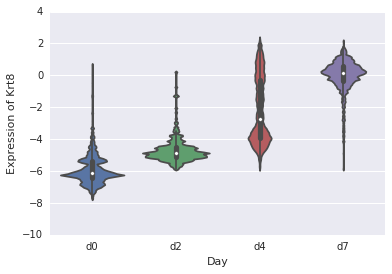

In [24]:
ax = sns.violinplot(x=flatten(xin),y=flatten(yin_imputed),bw=0.05)
ax.set(xlabel = 'Day',ylabel='Expression of Krt8')

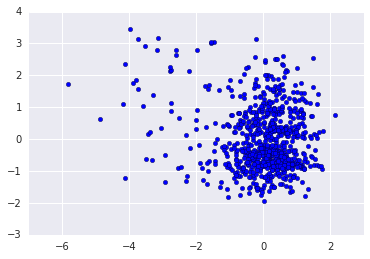

In [25]:
plt.scatter(norm_imputed2[3][0],norm_imputed2[3][1])

In [26]:
train_data = map(norm_imputed2.__getitem__,[0,1,2,3])
train_times = map(times.__getitem__,[0,1,2,3])

In [27]:
train_times

[0.0, 2.0, 4.0, 7.0]

## Baseline

In [28]:
tid = 2
qsvec = np.std(train_data[tid],axis=1)

In [29]:
def quadratic_flow(v):
    return -v/(2*qsvec[:,np.newaxis])

In [30]:
np.random.seed(0)
p_sub=np.random.choice(train_data[0].shape[1],size=5000,replace=True)
q_in = np.copy(train_data[0][:,p_sub])
q_out = euler_maruyama_dist(q_in,quadratic_flow,0.01,train_times[tid],np.sqrt(2))

In [31]:
err_out, fval=error_term(q_out,train_data[tid],0.1)
print fval

3553.50812842


## Run potential learning

In [32]:
sdin=1.0

-inf
-inf
-118.798539101
-52.3322954533
-73.3641076494
(-100.89322775711409, 1.0000000000000001e-07)
(-112.83000295552685, 5.0000000000000004e-08)
(-122.30987202550349, 2.5000000000000002e-08)
(-225.94863124100118, 1.2500000000000001e-08)
(-179.6116419509469, 6.2500000000000005e-09)
-115.17606838


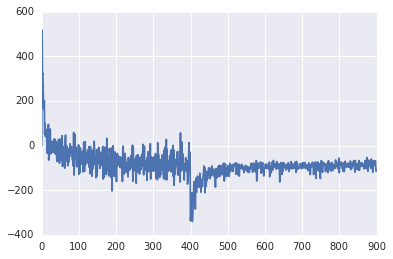

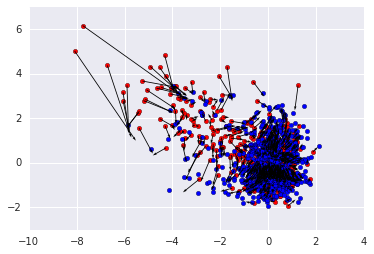

In [33]:
np.random.seed(0)
parout_2 = run_all([train_data[0],train_data[-1]], [train_times[0],train_times[-1]], relu_pack, sdin=sdin,dtin=0.1, tau=0.7, n1=5,n2=5,lossfun=sinkhorn_error, Knum=500, eps_base=0.1,scale_base=0.00001)

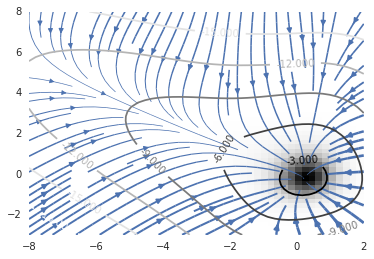

In [34]:
x_test = np.linspace(-8,2,num=50)
y_test = np.linspace(-3,8,num=50)
plt.figure()
plot_flow_both(x_test,y_test,parout_2[1])

In [35]:
def nonpar_stat_drift(pts,evalpt,k):
    dist = get_dist(evalpt,pts)
    topk = [np.argsort(dist[i,:])[:k] for i in xrange(dist.shape[0])]
    emu = np.vstack([(np.mean(pts[:,topk[i]],1)-evalpt[:,i])/(dist[i,topk[i][k-1]]) for i in xrange(len(topk))])
    return emu

In [36]:
from itertools import product
x_test = np.linspace(-6,2,num=50)
y_test = np.linspace(-3,8,num=50)
eval_list = np.array(list(product(x_test, y_test)))
evalpt = np.transpose(eval_list)
delt=nonpar_stat_drift(train_data[-1],evalpt,30)
d1=np.reshape(delt[:,0],(len(x_test),len(y_test))).T
d2=np.reshape(delt[:,1],(len(x_test),len(y_test))).T

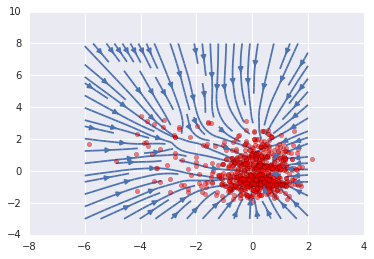

In [37]:
plt.streamplot(x_test,y_test,d1,d2)
plt.scatter(train_data[-1][0],train_data[-1][1],alpha=0.5,c='red')

In [38]:
x_test = np.linspace(-6,2,num=50)
y_test = np.linspace(-3,5,num=50)

In [39]:
it_end2 = parout_2[0].simulate(train_data[0],200,20,0.1,1e-10)

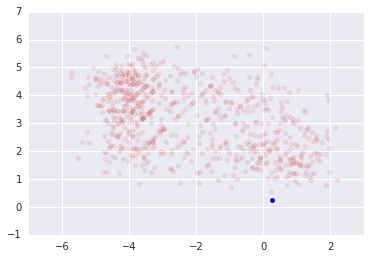

In [40]:
plt.scatter(it_end2[0][0],it_end2[0][1])
plt.scatter(train_data[2][0],train_data[2][1],c='red',alpha=0.1)

## Forecasting

In [41]:
np.random.seed(0)
forecast_gexp = parout_2[1].simulate(train_data[0],2000,4,0.01,1.0)

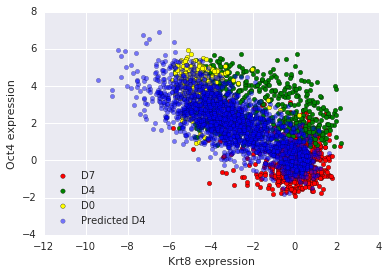

In [42]:
idj = 1
plt.scatter(norm_imputed2[3][0],norm_imputed2[3][idj],c='red',label='D7')
plt.scatter(norm_imputed2[2][0],norm_imputed2[2][idj],c='green',label='D4')
plt.scatter(norm_imputed2[1][0],norm_imputed2[1][idj],c='yellow',label='D0')
plt.scatter(forecast_gexp[0],forecast_gexp[idj],label='Predicted D4',alpha=0.5)
plt.legend(loc='lower left')
plt.xlabel('Krt8 expression')
plt.ylabel('Oct4 expression')

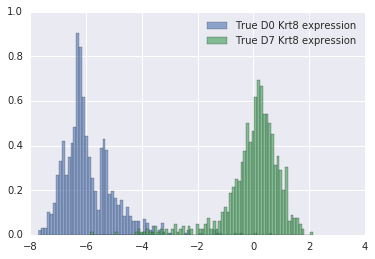

In [43]:
x1=plt.hist(norm_imputed2[0][0],80,alpha=0.6,normed=True,label='True D0 Krt8 expression')
x2=plt.hist(norm_imputed2[3][0],80,alpha=0.7,normed=True,label='True D7 Krt8 expression')
plt.legend(loc='upper right')
plt.show()

In [44]:
from scipy.stats import gaussian_kde
def gksd(x,sd):
    density = gaussian_kde(x)
    density.covariance_factor = lambda : sd
    density._compute_covariance()
    return density

(-8, 3)

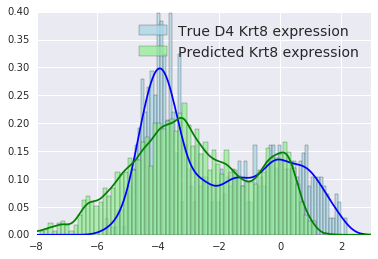

In [45]:
i=0
xs= np.linspace(-8,3,200)
x1=plt.hist(norm_imputed2[2][i],80,alpha=0.8,normed=True,label='True D4 Krt8 expression',color='lightblue')
plt.plot(xs,gksd(norm_imputed2[2][0],0.15)(xs),c='blue')
x2=plt.hist(forecast_gexp[i],80,alpha=0.7,normed=True,label='Predicted Krt8 expression',color='lightgreen')
plt.legend(loc='upper right',fontsize=14)
plt.plot(xs,gksd(forecast_gexp[0],0.1)(xs),c='green')
plt.xlim((-8,3))

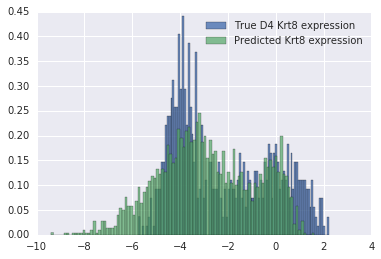

In [46]:
x1=plt.hist(norm_imputed2[2][0],100,alpha=0.8,normed=True,label='True D4 Krt8 expression')
x2=plt.hist(forecast_gexp[0],100,alpha=0.7,normed=True,label='Predicted Krt8 expression')
plt.legend(loc='upper right')
plt.show()

## Multidim

# d=5

In [83]:
subvec = np.array([0,3,7,8,9])

gnvec = gene_names[w_order[subvec]]

cov_mat = np.cov(norm_imputed[3][subvec,:])
whiten = np.diag(np.diag(cov_mat)**(-0.5))
unwhiten = np.diag(np.diag(cov_mat)**(0.5))

norm_imputed2 = [np.dot(whiten,(normin - norm_adj)[subvec,:]) for normin in norm_imputed]
train_dat1 = [norm_imputed2[1],norm_imputed2[3]]

In [84]:
init_dat = np.hstack(train_dat1)
np.random.seed(0)
Kin = 2000
init_par=parset(potin=relu_pack,K=Kin,D=init_dat.shape[0],scale=0.01)

init_par.g_vec = np.zeros(Kin)
init_par.W_matrix = np.random.randn(Kin,init_dat.shape[0])*1.0
init_par.b_vec = np.diag(np.dot(init_par.W_matrix, p_samp(init_dat,Kin)))

init_par, p_mat = run_logp_theano(init_par,init_dat,500,0.0002,relu_pack,dt=0.5, burnin=50, ns=1000, ctk=True, ada_val=1/100.0)

In [85]:
h_par=init_par.copy()
h_par.g_vec = h_par.g_vec*4.0
sdin2 = np.sqrt(2)
h_hyp=hyperpars(NS=500,eps=1e-12,sd=sdin2,sdkern=None,dt=0.1,time=7.0)
h_dat=observed(norm_imputed2[0],norm_imputed2[3])
parout = run_grad_theano(h_dat,h_par,h_hyp,100,relu_pack,tau=0.7,burnin=50,lossfun=wasserstein_error,ada_val=0.01,debug=False)

In [86]:
np.random.seed(0)
init_par2 = init_par.copy()
init_par2.g_vec = init_par2.g_vec*4.0
forecast_gexp_mdim = init_par2.simulate(norm_imputed2[0],2000,4,0.1,sdin2)

In [87]:
parout2 = parout.copy()
forecast_gexp_mdim = parout2.simulate(norm_imputed2[0],2000,4.0,0.1,sdin2)

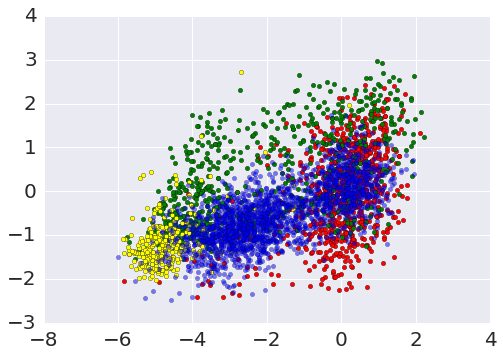

In [88]:
plt.scatter(norm_imputed2[3][0],norm_imputed2[3][idj],c='red',label='D7')
plt.scatter(norm_imputed2[2][0],norm_imputed2[2][idj],c='green',label='D4')
plt.scatter(norm_imputed2[1][0],norm_imputed2[1][idj],c='yellow',label='D0')
plt.scatter(forecast_gexp_mdim[0],forecast_gexp_mdim[1],alpha=0.5)


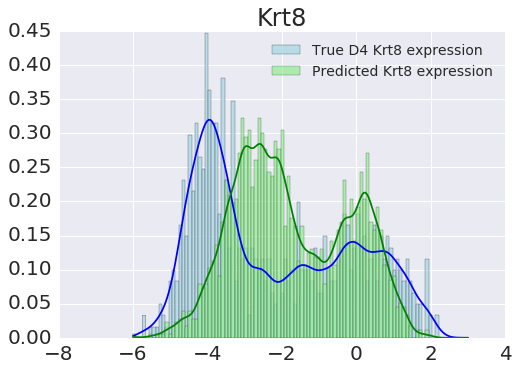

In [89]:
i=0
x1=plt.hist(norm_imputed2[2][i],90,alpha=0.8,normed=True,label='True D4 '+gnvec[i]+' expression',color='lightblue')
plt.plot(xs,gksd(norm_imputed2[2][0],0.1)(xs),c='blue')
x2=plt.hist(forecast_gexp_mdim[i],90,alpha=0.7,normed=True,label='Predicted '+gnvec[i]+' expression',color='lightgreen')
plt.legend(loc='upper right',fontsize=14)
xs = np.linspace(-6,3,200)
plt.plot(xs,gksd(forecast_gexp_mdim[0],0.1)(xs),c='green')
plt.title(gnvec[i])

In [90]:
ou_fit = run_all([norm_imputed2[0],norm_imputed2[3]],[0.0,7.0],ou_pack,sdin=sdin2,tau=0.7,eps_base=1e-8,Knum=100,dtin=1.0,debug=False)
lin_fit = run_all([norm_imputed2[0],norm_imputed2[3]],[0.0,7.0],lin_pack,sdin=sdin2,tau=0.0,eps_base=1e-8,Knum=100,dtin=1.0,debug=False)
loc_fit = run_all([norm_imputed2[0],norm_imputed2[3]],[0.0,7.0],local_pack,sdin=sdin2,tau=0.0,eps_base=1e-8,Knum=100,dtin=1.0,debug=False)

In [91]:
forecast_ou = ou_fit[0].simulate(norm_imputed2[0],2000,4,0.01,sdin2)
forecast_lin = lin_fit[0].simulate(norm_imputed2[0],2000,4,0.01,sdin2)
forecast_loc = loc_fit[0].simulate(norm_imputed2[0],2000,4,0.01,sdin2)

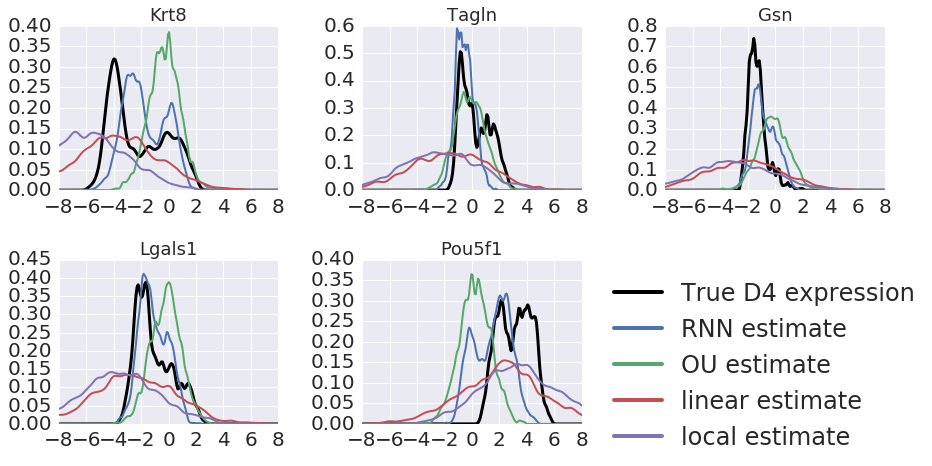

In [94]:
plt.figure(figsize=(13,13))
for i in xrange(5):
    plt.subplot(4,3,i+1)
    xs = np.linspace(-8,8,200)
    l1 = plt.plot(xs,gksd(norm_imputed2[2][i],0.1)(xs),linewidth=3,color='black',label='True D4 expression')
    l2 = plt.plot(xs,gksd(forecast_gexp_mdim[i],0.1)(xs),label='RNN estimate',linewidth=2)
    l3 = plt.plot(xs,gksd(forecast_ou[i],0.1)(xs),label='OU estimate',linewidth=2)
    l4 = plt.plot(xs,gksd(forecast_lin[i],0.1)(xs),label='linear estimate',linewidth=2)
    l5 = plt.plot(xs,gksd(forecast_loc[i],0.1)(xs),label='local estimate',linewidth=2)
    plt.title(gnvec[i],fontsize=18)
plt.legend(bbox_to_anchor=(1.05,1),loc=2,fontsize=24)

leg = plt.gca().get_legend()
llines = leg.get_lines()
plt.setp(llines,linewidth=4)
plt.tight_layout()
plt.show()

In [95]:
par_list = [parout2, ou_fit[0], lin_fit[0], loc_fit[0]]
err_mat_5d = np.zeros((5,4))
for i in xrange(5):
    tmp_vec = []
    for par in par_list:
        fcast = par.simulate(norm_imputed2[0],2000,4.0,0.1,sdin2)
        errvec, err = sinkhorn_error(fcast , norm_imputed2[2], None)
        tmp_vec.append(err)
    err_mat_5d[i,:] = np.array(tmp_vec)

In [96]:
err_base_5d = sinkhorn_error(p_samp(norm_imputed2[3],2000),norm_imputed2[2],None)[1]

In [97]:
err_mat_5d

array([[ -5987.88850036,  -9830.54231147, -54335.17738366, -70323.30072096],
       [ -6189.44558566,  -9579.84656424, -50833.06614139, -72329.35680209],
       [ -6205.45375553,  -9752.12119191, -50353.58950962, -74393.01141533],
       [ -5928.79948151,  -9125.59434387, -53018.47845471, -71728.69084558],
       [ -6368.76007355,  -9661.59971393, -54849.22648121, -74960.82905202]])

# d=10

In [98]:
subvec = np.array([0,1,2,3,4,5,6,7,8,9])

gnvec = gene_names[w_order[subvec]]

cov_mat = np.cov(norm_imputed[3][subvec,:])
whiten = np.diag(np.diag(cov_mat)**(-0.5))
unwhiten = np.diag(np.diag(cov_mat)**(0.5))

norm_imputed2 = [np.dot(whiten,(normin - norm_adj)[subvec,:]) for normin in norm_imputed]
train_dat1=[norm_imputed2[1],norm_imputed2[3]]

In [99]:
init_dat = np.hstack(train_dat1)
np.random.seed(0)
Kin = 2000
init_par=parset(potin=relu_pack,K=Kin,D=init_dat.shape[0],scale=0.01)


init_par.g_vec = np.zeros(Kin)
init_par.W_matrix = np.random.randn(Kin,init_dat.shape[0])*1.0
init_par.b_vec = np.diag(np.dot(init_par.W_matrix, p_samp(init_dat,Kin)))

init_par, p_mat = run_logp_theano(init_par,init_dat,500,0.0002,relu_pack,dt=0.5, burnin=50, ns=1000, ctk=True, ada_val=1/100.0)

In [100]:
h_par=init_par.copy()
h_par.g_vec = h_par.g_vec*4.0
sdin2 = np.sqrt(2)
h_hyp=hyperpars(NS=500,eps=1e-9,sd=sdin2,sdkern=None,dt=0.1,time=7.0)
h_dat=observed(norm_imputed2[0],norm_imputed2[3])
parout = run_grad_theano(h_dat,h_par,h_hyp,100,relu_pack,tau=0.7,burnin=50,lossfun=wasserstein_error,ada_val=0.01,debug=False)

In [101]:
np.random.seed(0)
init_par2 = init_par.copy()
init_par2.g_vec = init_par2.g_vec*4.0
forecast_gexp_mdim = init_par2.simulate(norm_imputed2[0],2000,4,0.1,sdin2)

In [102]:
parout2 = parout.copy()
forecast_gexp_mdim = parout2.simulate(norm_imputed2[0],2000,4.0,0.1,sdin2)

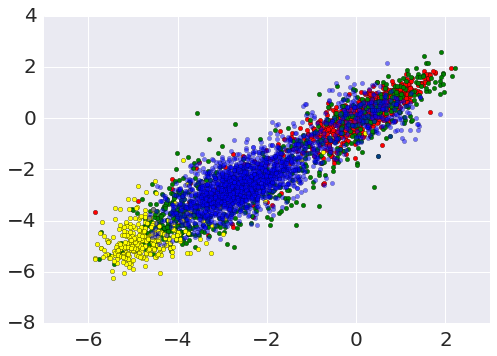

In [103]:
plt.scatter(norm_imputed2[3][0],norm_imputed2[3][idj],c='red',label='D7')
plt.scatter(norm_imputed2[2][0],norm_imputed2[2][idj],c='green',label='D4')
plt.scatter(norm_imputed2[1][0],norm_imputed2[1][idj],c='yellow',label='D0')
plt.scatter(forecast_gexp_mdim[0],forecast_gexp_mdim[1],alpha=0.5)


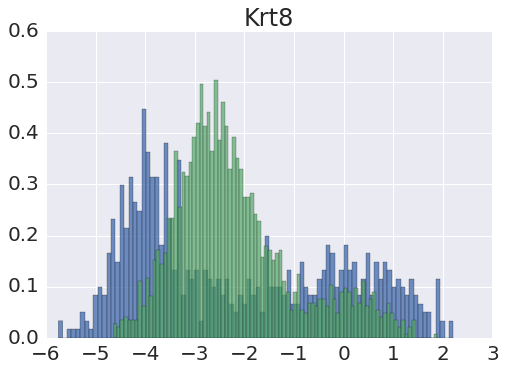

In [104]:
i=0
x1=plt.hist(norm_imputed2[2][i],90,alpha=0.8,normed=True,label='True D4 '+gnvec[i]+' expression')
x2=plt.hist(forecast_gexp_mdim[i],90,alpha=0.7,normed=True,label='Predicted '+gnvec[i]+' expression')
#plt.legend(loc='upper right')
plt.title(gnvec[i])

In [106]:
ou_fit = run_all([norm_imputed2[0],norm_imputed2[3]],[0.0,7.0],ou_pack,sdin=sdin2,tau=0.7,eps_base=1e-8,Knum=100,dtin=1.0,debug=False)
forecast_ou = ou_fit[0].simulate(norm_imputed2[0],2000,4,0.01,sdin2)

lin_fit = run_all([norm_imputed2[0],norm_imputed2[3]],[0.0,7.0],lin_pack,sdin=sdin2,tau=0.0,eps_base=1e-8,Knum=100,dtin=1.0,debug=False)
forecast_lin = lin_fit[0].simulate(norm_imputed2[0],2000,4,0.01,sdin2)

loc_fit = run_all([norm_imputed2[0],norm_imputed2[3]],[0.0,7.0],local_pack,sdin=sdin2,tau=0.0,eps_base=1e-8,Knum=100,dtin=1.0,debug=False)
forecast_loc = loc_fit[0].simulate(norm_imputed2[0],2000,4,0.01,sdin2)

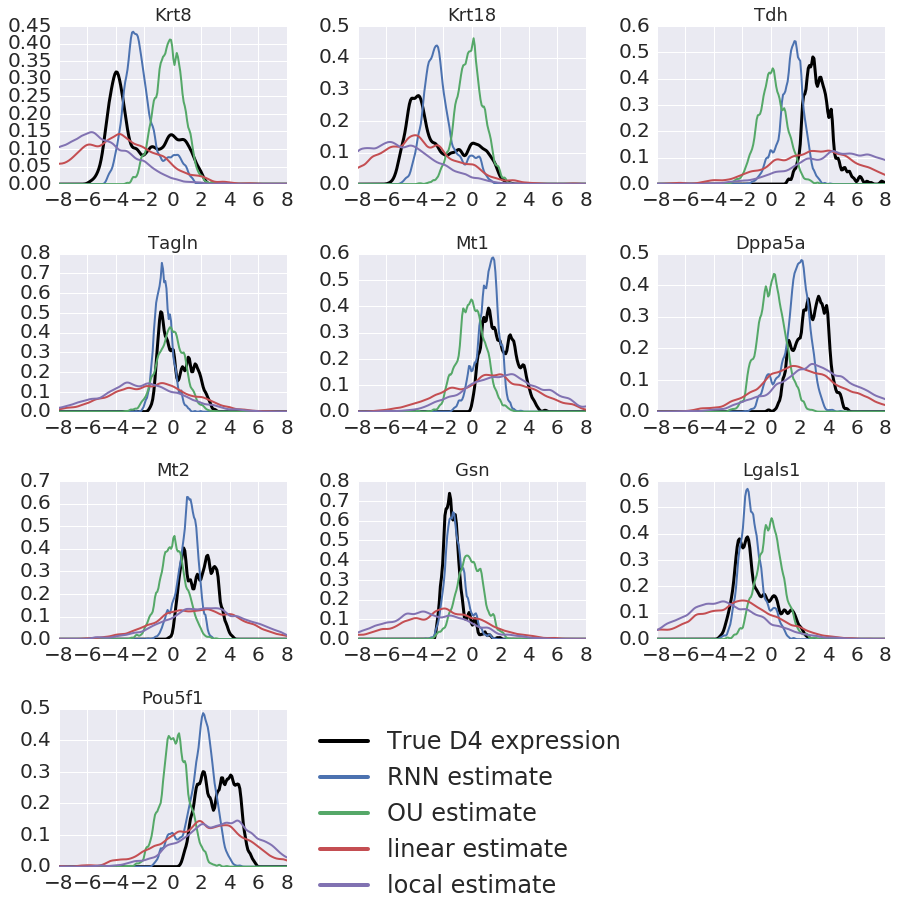

In [107]:
plt.figure(figsize=(13,13))
for i in xrange(10):
    plt.subplot(4,3,i+1)
    xs = np.linspace(-8,8,200)
    l1 = plt.plot(xs,gksd(norm_imputed2[2][i],0.1)(xs),linewidth=3,color='black',label='True D4 expression')
    l2 = plt.plot(xs,gksd(forecast_gexp_mdim[i],0.1)(xs),label='RNN estimate',linewidth=2)
    l3 = plt.plot(xs,gksd(forecast_ou[i],0.1)(xs),label='OU estimate',linewidth=2)
    l4 = plt.plot(xs,gksd(forecast_lin[i],0.1)(xs),label='linear estimate',linewidth=2)
    l5 = plt.plot(xs,gksd(forecast_loc[i],0.1)(xs),label='local estimate',linewidth=2)
    plt.title(gnvec[i],fontsize=18)
plt.legend(bbox_to_anchor=(1.05,1),loc=2,fontsize=24)

leg = plt.gca().get_legend()
llines = leg.get_lines()
plt.setp(llines,linewidth=4)
plt.tight_layout()
plt.show()

In [108]:
pd.DataFrame(np.corrcoef(norm_imputed2[2]))

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.920438,-0.062465,0.617045,-0.360361,-0.192449,-0.286122,0.488132,0.729461,-0.444885
1,0.920438,1.000000,-0.087822,0.618581,-0.375673,-0.187396,-0.282206,0.483281,0.742209,-0.438065
2,-0.062465,-0.087822,1.000000,-0.128269,0.214066,0.037070,0.148094,0.222628,-0.035910,0.030767
3,0.617045,0.618581,-0.128269,1.000000,-0.366692,-0.122659,-0.326493,0.301840,0.457948,-0.219974
4,-0.360361,-0.375673,0.214066,-0.366692,1.000000,0.183506,0.784577,-0.144599,-0.181026,0.244942
5,-0.192449,-0.187396,0.037070,-0.122659,0.183506,1.000000,0.226702,-0.235209,-0.192908,0.174021
6,-0.286122,-0.282206,0.148094,-0.326493,0.784577,0.226702,1.000000,-0.153899,-0.105207,0.192293
7,0.488132,0.483281,0.222628,0.301840,-0.144599,-0.235209,-0.153899,1.000000,0.494841,-0.191262
8,0.729461,0.742209,-0.035910,0.457948,-0.181026,-0.192908,-0.105207,0.494841,1.000000,-0.366521
9,-0.444885,-0.438065,0.030767,-0.219974,0.244942,0.174021,0.192293,-0.191262,-0.366521,1.000000


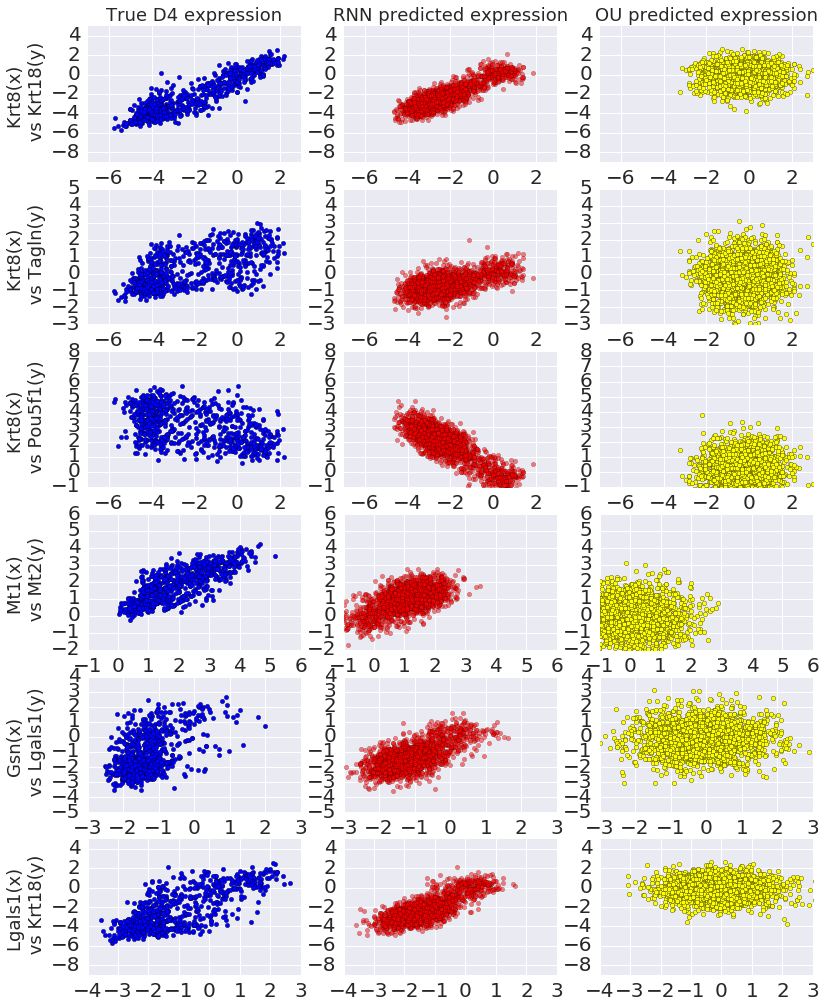

In [109]:
plt.figure(figsize=(13,17))



ijlist = [[0,1],[0,3],[0,9],[4,6],[7,8],[8,1]]
i=0
ijmax = len(ijlist)

fig, axes = plt.subplots(nrows=ijmax, ncols=3, figsize=(13, 17))
for ijpair in ijlist:
    ax = plt.subplot(ijmax,3,i+1)
    plt.scatter(norm_imputed2[2][ijpair[0]],norm_imputed2[2][ijpair[1]])
    ax.set_ylim([ax.get_ylim()[0]-1,ax.get_ylim()[1]+1])
    plt.ylabel(gnvec[ijpair[0]]+'(x) \n vs '+gnvec[ijpair[1]]+'(y)', fontsize=18)
    if i is 0:
        plt.title('True D4 expression',fontsize=18)        
    ax2 = plt.subplot(ijmax,3,i+2)
    plt.scatter(forecast_gexp_mdim[ijpair[0]],forecast_gexp_mdim[ijpair[1]],c='red',alpha=0.5)
    ax2.set_xlim(ax.get_xlim())
    ax2.set_ylim(ax.get_ylim())
    if i is 0:
        plt.title('RNN predicted expression',fontsize=18)
    ax3 = plt.subplot(ijmax,3,i+3)
    plt.scatter(forecast_ou[ijpair[0]],forecast_ou[ijpair[1]],c='yellow')
    ax3.set_xlim(ax.get_xlim())
    ax3.set_ylim(ax.get_ylim())
    if i is 0:
        plt.title('OU predicted expression',fontsize=18)
    i=i+3

In [110]:
par_list = [parout2, ou_fit[0], lin_fit[0], loc_fit[0]]
err_mat_10d = np.zeros((5,4))
for i in xrange(5):
    tmp_vec = []
    for par in par_list:
        fcast = par.simulate(norm_imputed2[0],2000,4.0,0.1,sdin2)
        errvec, err = sinkhorn_error(fcast , norm_imputed2[2], None)
        tmp_vec.append(err)
    err_mat_10d[i,:] = np.array(tmp_vec)

In [111]:
err_mat_10d

array([[ -20924.48323254,  -55762.27368078, -117431.96657912,
        -140476.89567405],
       [ -20837.29561796,  -55485.53284418, -115458.25821581,
        -143820.05828967],
       [ -20411.13955019,  -52050.41518471, -118352.46002595,
        -143187.78614122],
       [ -21497.80082428,  -49585.23878805, -115913.52578605,
        -144859.0607841 ],
       [ -20102.95174635,  -54422.72319623, -117193.11481514,
        -142689.09216994]])

In [112]:
err_base_10d = sinkhorn_error(p_samp(norm_imputed2[3],2000),norm_imputed2[2],None)[1]

In [113]:
mu_mat_5d = -np.mean(err_mat_5d,0)
mu_mat_10d = -np.mean(err_mat_10d,0)
sd_mat_5d = np.std(np.log(-1*err_mat_5d),0)
sd_mat_10d = np.std(err_mat_10d,0)

In [114]:
vec_seq = np.hstack([-1*err_base_5d,mu_mat_5d,-1*err_base_10d,mu_mat_10d])

In [115]:
hvec  = ['Baseline (predict with D7 data)','RNN','OU','Linear','Local','Baseline (predict with D7 data)','RNN','OU','Linear','Local']

In [116]:
xvec = ['5d','5d','5d','5d','5d','10d','10d','10d','10d','10d']

(5000, 200000)

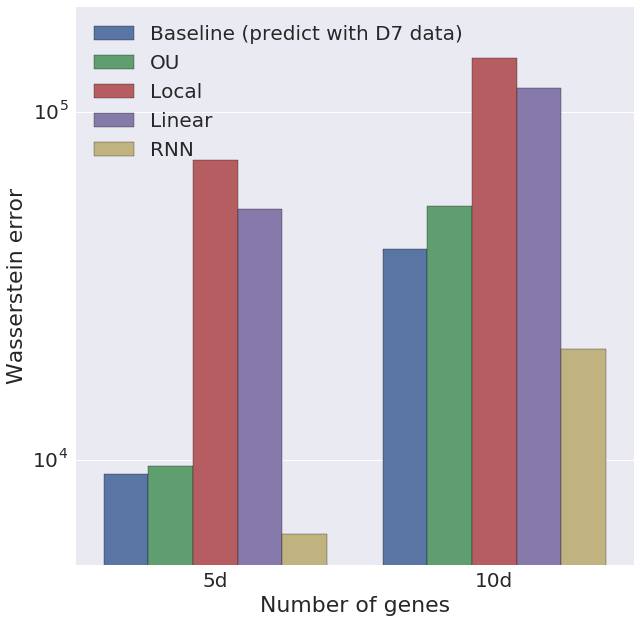

In [117]:
plt.figure(figsize=(10,10))
sns.set(font_scale=2)
ax = sns.barplot(x=xvec,hue=hvec,y=vec_seq, hue_order=['Baseline (predict with D7 data)','OU','Local','Linear','RNN'])
ax.set(xlabel='Number of genes',ylabel='Wasserstein error',yscale='log')
plt.ylim((5000,200000))